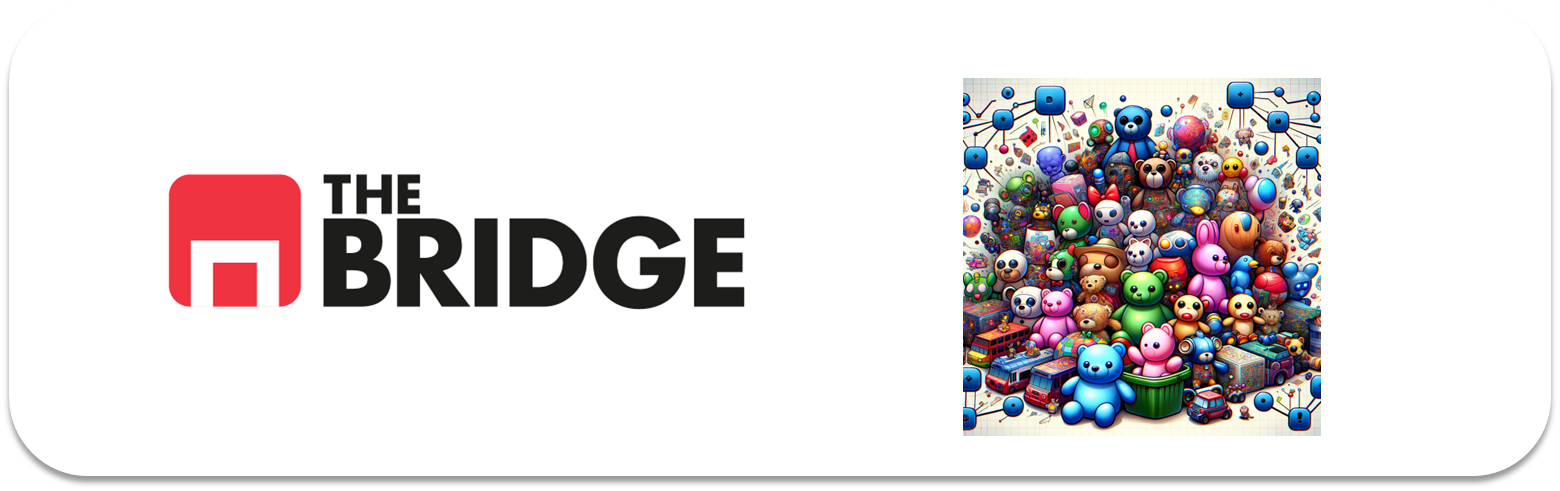

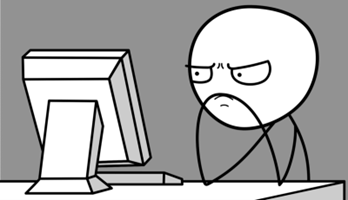

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [3]:
df = pd.read_csv("./data/drugLibTrain_raw.tsv", sep="\t")


In [4]:
df.head(5)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [6]:
# Obtener la cardinalidad (número de valores únicos) de cada columna categórica
cardinalidad = df.nunique()

# Calcular el porcentaje de cardinalidad respecto al número total de filas
porcentaje_cardinalidad = (cardinalidad / len(df)) * 100

# Crear un DataFrame con los resultados
cardinalidad_df = pd.DataFrame({
    "Feature": df.columns,
    "Valores Únicos": cardinalidad.values,
    "Porcentaje Cardinalidad": porcentaje_cardinalidad.values
})

# Ordenar de mayor a menor cardinalidad
cardinalidad_df.sort_values(by="Porcentaje Cardinalidad", ascending=False)


,Feature,Valores Únicos,Porcentaje Cardinalidad
0,Unnamed: 0,3107,100.000000
8,commentsReview,3046,98.036691
6,benefitsReview,3031,97.553911
7,sideEffectsReview,2813,90.537496
5,condition,1426,45.896363
1,urlDrugName,502,16.157065
2,rating,10,0.321854
3,effectiveness,5,0.160927
4,sideEffects,5,0.160927


In [7]:
# Descartamos `urlDrugName` y columnas con cardinalidad alta si es necesario
columnas_a_descartar = ["urlDrugName"]

# Aplicar un umbral de descarte (ejemplo: columnas con más del 90% de valores únicos)
umbral = 90
columnas_a_descartar += cardinalidad_df[cardinalidad_df["Porcentaje Cardinalidad"] > umbral]["Feature"].tolist()

# Crear nuevo DataFrame con columnas seleccionadas
df_filtrado = df.drop(columns=columnas_a_descartar)

# Verificar resultado
print(df_filtrado.head())


   rating         effectiveness          sideEffects  \
0       4      Highly Effective    Mild Side Effects   
1       1      Highly Effective  Severe Side Effects   
2      10      Highly Effective      No Side Effects   
3       3  Marginally Effective    Mild Side Effects   
4       2  Marginally Effective  Severe Side Effects   

                                condition  
0  management of congestive heart failure  
1                        birth prevention  
2                        menstrual cramps  
3                             acid reflux  
4                            fibromyalgia  


### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [8]:
# Definir X con las columnas seleccionadas
X = df_filtrado.copy()

# Verificar la forma de X
print(X.shape)
print(X.head())


(3107, 4)
   rating         effectiveness          sideEffects  \
0       4      Highly Effective    Mild Side Effects   
1       1      Highly Effective  Severe Side Effects   
2      10      Highly Effective      No Side Effects   
3       3  Marginally Effective    Mild Side Effects   
4       2  Marginally Effective  Severe Side Effects   

                                condition  
0  management of congestive heart failure  
1                        birth prevention  
2                        menstrual cramps  
3                             acid reflux  
4                            fibromyalgia  


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Seleccionamos las columnas categóricas
cat_columns = ["effectiveness", "sideEffects", "condition"]

# Aplicamos OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore")
cat_encoded = encoder.fit_transform(X[cat_columns])

# Nombres de las nuevas columnas creadas
cat_feature_names = encoder.get_feature_names_out(cat_columns)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rating_scaled = scaler.fit_transform(X[["rating"]])


In [12]:
# Concatenar las transformaciones en una sola matriz
X_transformed = np.hstack([rating_scaled, cat_encoded])

# Ver la nueva forma del dataset
print(X_transformed.shape)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [17]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar OneHotEncoder con el parámetro correcto
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_encoded = encoder.fit_transform(X[["effectiveness", "sideEffects", "condition"]])

# Verificar la forma de cat_encoded
print("Forma de cat_encoded:", cat_encoded.shape)


Forma de cat_encoded: (3107, 1437)


In [18]:
# Asegurar que rating_scaled es 2D
rating_scaled = rating_scaled.reshape(-1, 1)

# Concatenar las matrices
X_transformed = np.hstack([rating_scaled, cat_encoded])

# Verificar la forma final
print("Forma final de X_transformed:", X_transformed.shape)


Forma final de X_transformed: (3107, 1438)


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

In [19]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir la dimensionalidad a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Verificar la forma de X_pca
print(X_pca.shape)


(3107, 2)


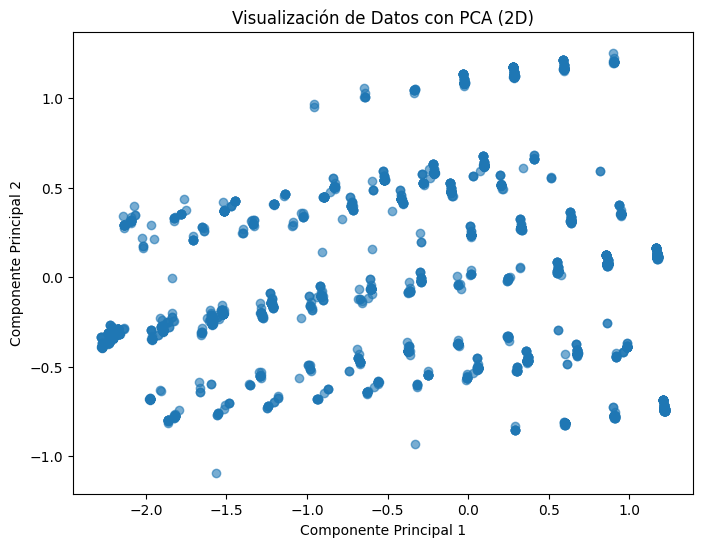

In [20]:
import matplotlib.pyplot as plt

# Crear el scatter plot de las dos primeras componentes principales
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("Visualización de Datos con PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()


### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

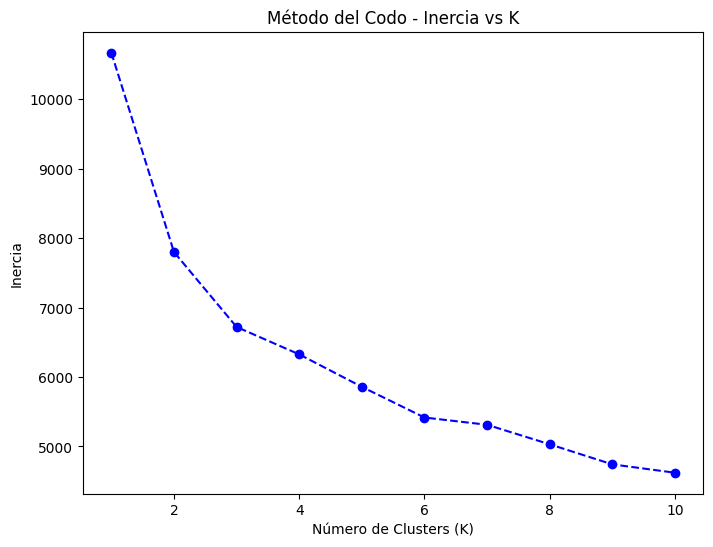

In [21]:
from sklearn.cluster import KMeans

# Rango de K para probar (puedes cambiar estos valores si lo deseas)
K_range = range(1, 11)

# Guardamos las inercia para cada K
inertia_values = []

# Evaluamos diferentes valores de K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)  # Usamos las características transformadas
    inertia_values.append(kmeans.inertia_)  # Guardamos la inercia

# Graficamos el método del codo
plt.figure(figsize=(8,6))
plt.plot(K_range, inertia_values, marker='o', color='b', linestyle='--')
plt.title("Método del Codo - Inercia vs K")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inercia")
plt.show()


### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

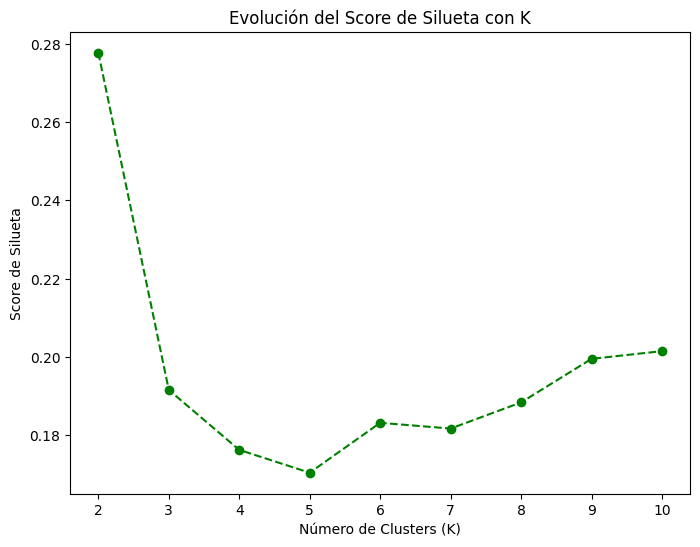

In [23]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Rango de K para probar (usamos el mismo rango que en el ejercicio anterior, pero comenzamos desde 2)
K_range = range(2, 11)  # Comenzamos desde 2

# Guardamos los scores de silueta para cada K
silhouette_scores = []

# Evaluamos diferentes valores de K
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)  # Usamos las características transformadas
    score = silhouette_score(X_transformed, kmeans.labels_)
    silhouette_scores.append(score)

# Graficamos la evolución del score de silueta con K
plt.figure(figsize=(8,6))
plt.plot(K_range, silhouette_scores, marker='o', color='g', linestyle='--')
plt.title("Evolución del Score de Silueta con K")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Score de Silueta")
plt.show()


### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

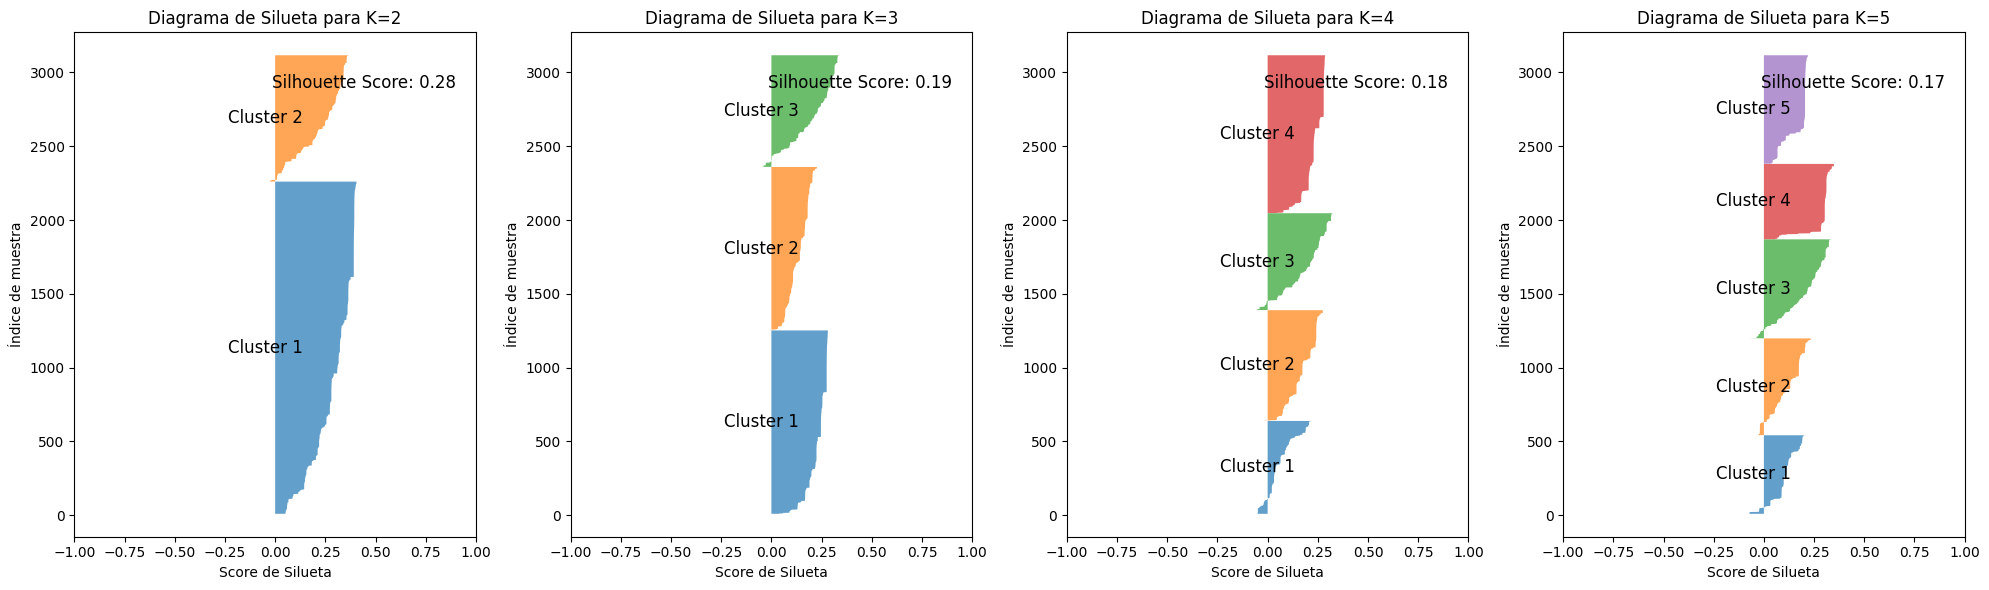

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Valores de K a evaluar
K_values = [2, 3, 4, 5]

# Crear una figura para mostrar los diagramas
fig, axes = plt.subplots(1, len(K_values), figsize=(20, 6))

for idx, k in enumerate(K_values):
    # Crear y ajustar el modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_transformed)  # Obtener las etiquetas de los clusters

    # Calcular los valores del score de silueta
    silhouette_vals = silhouette_samples(X_transformed, cluster_labels)

    # Crear el diagrama de silueta
    axes[idx].set_xlim([-1, 1])
    axes[idx].set_title(f"Diagrama de Silueta para K={k}")
    axes[idx].set_xlabel("Score de Silueta")
    axes[idx].set_ylabel("Índice de muestra")

    # Ordenar los valores de silueta
    y_lower = 10
    for i in range(k):
        # Seleccionar las muestras que pertenecen al cluster i
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()

        # Dibujar la silueta para este cluster
        size_cluster = len(cluster_silhouette_vals)
        axes[idx].fill_betweenx(np.arange(y_lower, y_lower + size_cluster),
                                0, cluster_silhouette_vals, alpha=0.7)
        axes[idx].text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {i + 1}',
                       fontsize=12, ha='center', va='center')

        # Actualizar la posición para el siguiente cluster
        y_lower += size_cluster

    # Mostrar el score de silueta global para cada K
    score = silhouette_score(X_transformed, cluster_labels)
    axes[idx].text(0.95, 0.9, f'Silhouette Score: {score:.2f}', transform=axes[idx].transAxes,
                   fontsize=12, va='center', ha='right')

# Ajustar y mostrar la figura
plt.tight_layout()
plt.show()


### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.


Centroides para K=2:
[[ 5.45151768e-01  3.48733896e-01  5.50866282e-01 ...  4.44247001e-04
   1.33274100e-03  1.51788304e-18]
 [-1.43357083e+00  1.67056075e-01  1.05140187e-01 ...  3.25260652e-19
   2.33644860e-03  1.16822430e-03]]


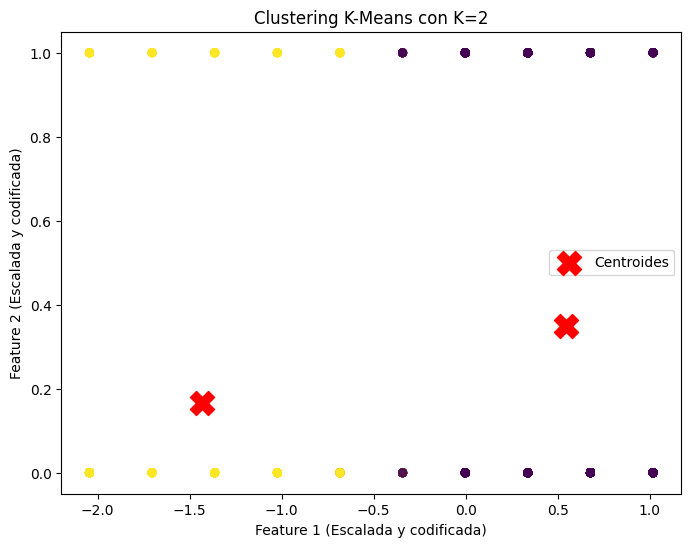


Centroides para K=3:
[[ 7.57197948e-01  7.21644966e-16  9.97586484e-01 ...  8.13151629e-19
   8.04505229e-04  8.13151629e-19]
 [ 2.08290143e-01  7.52484192e-01 -2.22044605e-16 ...  9.03342367e-04
   1.80668473e-03  7.04731412e-19]
 [-1.54791841e+00  1.25495376e-01  1.18890357e-01 ...  1.08420217e-19
   2.64200793e-03  1.32100396e-03]]


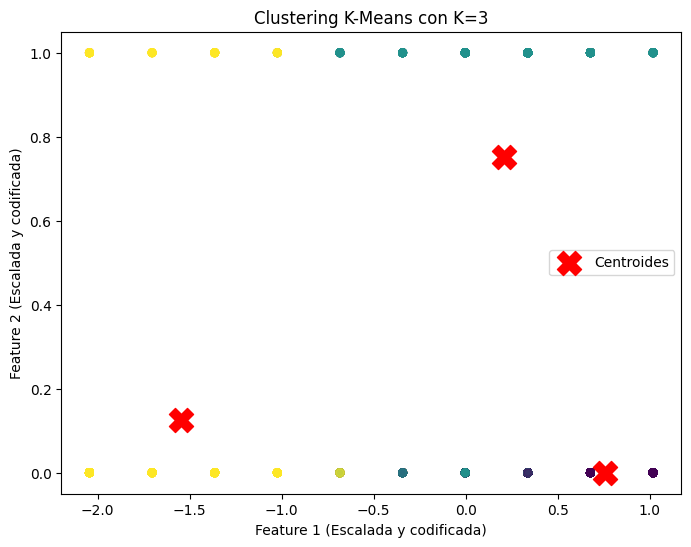

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Valores de K seleccionados (2 y 3)
K_values = [2, 3]

# Entrenar el modelo KMeans para K=2 y K=3
for k in K_values:
    # Crear y ajustar el modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)  # Ajustar el modelo con las características transformadas
    
    # Predecir las etiquetas de los clusters
    cluster_labels = kmeans.labels_
    
    # Mostrar el centroide de los clusters
    print(f"\nCentroides para K={k}:")
    print(kmeans.cluster_centers_)
    
    # Graficar los resultados de KMeans
    plt.figure(figsize=(8,6))
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=cluster_labels, cmap='viridis', s=30, alpha=0.6)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroides')
    plt.title(f'Clustering K-Means con K={k}')
    plt.xlabel("Feature 1 (Escalada y codificada)")
    plt.ylabel("Feature 2 (Escalada y codificada)")
    plt.legend()
    plt.show()


### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

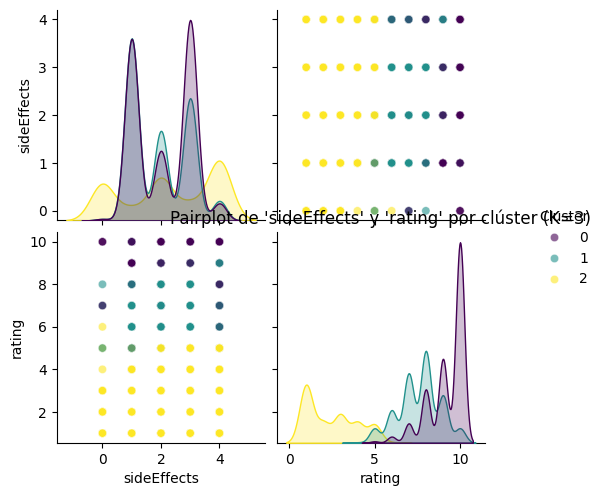

In [28]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Codificar la variable 'sideEffects' y 'rating' (si es necesario)
le = LabelEncoder()

# Codificar 'sideEffects' (si no está ya en formato numérico)
X_transformed_df['sideEffects'] = le.fit_transform(X_transformed_df['sideEffects'])

# 'rating' ya es numérica, por lo que no debería necesitar transformación, pero si es categórica, también podemos codificarla
# X_transformed_df['rating'] = le.fit_transform(X_transformed_df['rating'])

# Ahora generamos el pairplot considerando 'sideEffects' y 'rating' como variables de interés
sns.pairplot(X_transformed_df, vars=['sideEffects', 'rating'], hue='Cluster', palette='viridis', markers='o', plot_kws={'alpha': 0.6})
plt.title(f"Pairplot de 'sideEffects' y 'rating' por clúster (K={k_optimal})")
plt.show()


Estadísticas descriptivas por clúster:
        Feature_1                                                              \
            count      mean       std       min       25%       50%       75%   
Cluster                                                                         
0          1243.0  0.757198  0.352617 -0.683024  0.678860  1.019330  1.019330   
1          1107.0  0.208290  0.415525 -1.023494 -0.002082  0.338389  0.338389   
2           757.0 -1.547918  0.497478 -2.044907 -2.044907 -1.704436 -1.023494   

                  Feature_2            ... Feature_1437      Feature_1438  \
              max     count      mean  ...          75%  max        count   
Cluster                                ...                                  
0        1.019330    1243.0  0.000000  ...          0.0  1.0       1243.0   
1        1.019330    1107.0  0.752484  ...          0.0  1.0       1107.0   
2       -0.342553     757.0  0.125495  ...          0.0  1.0        757.0   

           

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

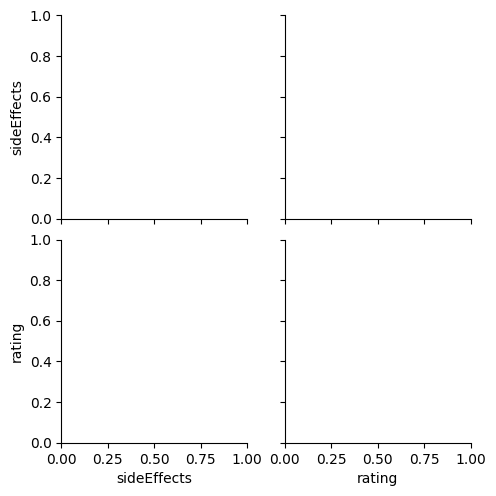

In [29]:
import seaborn as sns


# Valor óptimo K=3
k_optimal = 3

# Crear y entrenar el modelo KMeans con el K óptimo
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(X_transformed)

# Añadir las etiquetas de los clusters al DataFrame original para análisis posterior
X_transformed_df = pd.DataFrame(X_transformed, columns=[f"Feature_{i+1}" for i in range(X_transformed.shape[1])])
X_transformed_df['Cluster'] = cluster_labels

# Mostrar el valor medio de las características por clúster
print("Estadísticas descriptivas por clúster:")
print(X_transformed_df.groupby('Cluster').describe())


# Añadir las columnas relevantes al DataFrame transformado
X_transformed_df['rating'] = X['rating']  # Si rating ya está presente en X
X_transformed_df['sideEffects'] = X['sideEffects']  # Si sideEffects ya está presente en X

# Generar el pairplot con 'sideEffects' y 'rating' como variables de interés
sns.pairplot(X_transformed_df, vars=['sideEffects', 'rating'], hue='Cluster', palette='viridis', markers='o', plot_kws={'alpha': 0.6})
plt.title(f"Pairplot de 'sideEffects' y 'rating' por clúster (K={k_optimal})")
plt.show()


### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.